In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import sys,os,glob,json,pickle
from collections import OrderedDict

import libstempo as T2
import libstempo.toasim as LT
import libstempo.plot as LP

import enterprise
from enterprise.pulsar import Pulsar

import astropy.units as u

In [3]:
current_path = os.getcwd()
splt_path = current_path.split("/")
top_path_idx = splt_path.index('NANOGrav')
top_directory = "/".join(splt_path[0:top_path_idx+1])

sys.path.insert(0,top_directory)

import my_toasim as MyT
import toasim as LTTest

In [4]:
def get_noise_from_pal2(noisefile):
    psrname = noisefile.split('/')[-1].split('_noise.txt')[0]
    fin = open(noisefile, 'r')
    lines = fin.readlines()
    params = {}
    for line in lines:
        ln = line.split()
        if 'efac' in line:
            par = 'efac'
            flag = ln[0].split('efac-')[-1]
        elif 'equad' in line:
            par = 'log10_equad'
            flag = ln[0].split('equad-')[-1]
        elif 'jitter_q' in line:
            par = 'log10_ecorr'
            flag = ln[0].split('jitter_q-')[-1]
        elif 'RN-Amplitude' in line:
            par = 'red_noise_log10_A'
            flag = ''
        elif 'RN-spectral-index' in line:
            par = 'red_noise_gamma'
            flag = ''
        else:
            break
        if flag:
            name = [psrname, flag, par]
        else:
            name = [psrname, par]
        pname = '_'.join(name)
        params.update({pname: float(ln[1])})
    return params

In [5]:
#Where the enterprise 11yr datafiles are
current_dir = os.getcwd()
splt_path = current_dir.split("/")
top_path_idx = splt_path.index('BackgroundInjections')
top_dir = "/".join(splt_path[0:top_path_idx+1])

parpath = top_dir + '/nano11/partim_new/'
timpath = top_dir + '/nano11/partim_new/'
noisepath = top_dir + '/nano11/noisefiles_new/'
psrlistpath = top_dir + '/nano11/psrlist_Tg3yr.txt'
#The pickled pulsars
psr_pickle_file = current_dir + '/enterprise_sim_pulsars.pickle'

In [6]:
print('##############################################################')
print('Injections in: ', current_dir)
print('##############################################################')
print('\n')

##############################################################
Injections in:  /home/andrew/Documents/Research/NANOGrav/BackgroundInjections/toasim_testing
##############################################################




Load 11yr pulsar list

In [7]:
encoding = "utf-8"
psrlist_bytes = np.loadtxt(psrlistpath,dtype='S42')
psrlist = []
for psr in psrlist_bytes:
    psrlist.append(psr.decode(encoding))

Load par, tim, and noisefiles for 11yr psrs

In [8]:
parfiles = sorted(glob.glob(parpath+'*.par'))
timfiles = sorted(glob.glob(timpath+'*.tim'))
noisefiles = sorted(glob.glob(noisepath+'*.txt'))

parfiles = [x for x in parfiles if x.split('/')[-1].split('.')[0].split('_')[0] in psrlist]
timfiles = [x for x in timfiles if x.split('/')[-1].split('.')[0].split('_')[0] in psrlist]
noisefiles = [x for x in noisefiles if x.split('/')[-1].split('_')[0] in psrlist]

print(len(parfiles),len(timfiles),len(noisefiles))

34 34 34


In [9]:
#######################################
# PASSING THROUGH TEMPO2 VIA libstempo
#######################################

t2psr = []
for ii in range(len(parfiles)):
    
    t2psr.append( T2.tempopulsar(parfile = parfiles[ii], timfile = timfiles[ii],
                                 maxobs=30000, ephem='DE436') )
    
    if np.any(np.isfinite(t2psr[ii].residuals())==False)==True:
        t2psr[ii] = T2.tempopulsar(parfile = parfiles[ii], timfile = timfiles[ii])
                 

    print('\r{0} of {1}'.format(ii+1,len(parfiles)),flush=True,end='')

34 of 34

In [10]:
noise_params = {}
for nf in noisefiles:
    noise_params.update(get_noise_from_pal2(nf))

In [11]:
#Now parse this large dictionary so that we can call noise parameters as noise_dict[pulsar name][noise type]
#Returns either floats or 2 column arrays of flags and values. 

noise_dict = {}
for p in psrlist:
    noise_dict[p]={}
    noise_dict[p]['equads'] = []
    noise_dict[p]['efacs'] = []
    noise_dict[p]['ecorrs'] = []
    for ky in list(noise_params.keys()):
        if p in ky:
            if 'equad' in ky:
                noise_dict[p]['equads'].append([ky.replace(p + '_' , ''), noise_params[ky]])
            if 'efac' in ky:
                noise_dict[p]['efacs'].append([ky.replace(p + '_' , ''), noise_params[ky]])
            if 'ecorr' in ky:
                noise_dict[p]['ecorrs'].append([ky.replace(p + '_' , ''), noise_params[ky]])
            if 'gamma' in ky:
                noise_dict[p]['RN_gamma'] = noise_params[ky]
            if 'log10_A' in ky:
                noise_dict[p]['RN_Amp'] = 10**noise_params[ky]
                
    noise_dict[p]['equads'] = np.array(noise_dict[p]['equads'])
    noise_dict[p]['efacs'] = np.array(noise_dict[p]['efacs'])
    noise_dict[p]['ecorrs'] = np.array(noise_dict[p]['ecorrs'])    
    
    if len(noise_dict[p]['ecorrs'])==0: #Easier to just delete these dictionary items if no ECORR values. 
        noise_dict[p].__delitem__('ecorrs')

In [33]:
#By using seeds we can  reproduce the dataset if need be. 
seed_efac = 1066
seed_equad = 1492
seed_jitter = 1776
seed_red = 1987
seed_gwb_1 = 1667
seed_gwb_2 = 1980

Make test pulsar

In [34]:
orig_psr = t2psr[0]
test_psr1 = T2.tempopulsar(parfile = parfiles[0], timfile = timfiles[0],
                                 maxobs=30000, ephem='DE436')
test_psr2 = T2.tempopulsar(parfile = parfiles[0], timfile = timfiles[0],
                                 maxobs=30000, ephem='DE436')
test_psr3 = T2.tempopulsar(parfile = parfiles[0], timfile = timfiles[0],
                                 maxobs=30000, ephem='DE436')

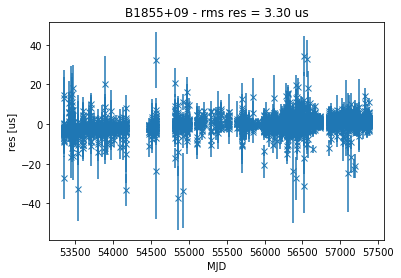

In [35]:
LP.plotres(orig_psr)

In [36]:
## add red noise
LTTest.add_rednoise(test_psr1, noise_dict[test_psr1.name]['RN_Amp'], noise_dict[test_psr1.name]['RN_gamma'], 
                components = 30, seed = seed_red)

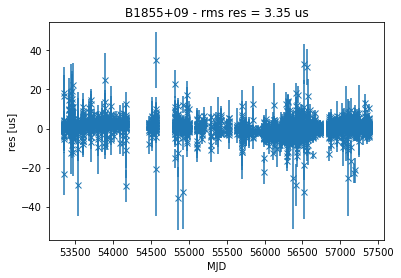

In [37]:
LP.plotres(test_psr1)

In [38]:
f_red_test_psr2,A_red_test_psr2 = MyT.add_rednoise(test_psr2, noise_dict[test_psr2.name]['RN_Amp'], noise_dict[test_psr2.name]['RN_gamma'], 
                components = 30, seed = seed_red)

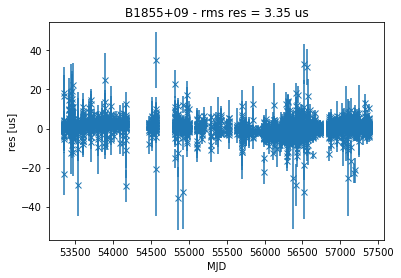

In [39]:
LP.plotres(test_psr2)

In [45]:
f_red_test_psr3,A_red_test_psr3 = MyT.add_rednoise(test_psr3, noise_dict[test_psr3.name]['RN_Amp'], noise_dict[test_psr3.name]['RN_gamma'], 
                components = 30, seed = seed_red,logspacing=True)

In [46]:
print(f_red_test_psr3)

[2.88126936e-09 2.88126936e-09 3.41943503e-09 3.41943503e-09
 4.05811969e-09 4.05811969e-09 4.81609835e-09 4.81609835e-09
 5.71565284e-09 5.71565284e-09 6.78322680e-09 6.78322680e-09
 8.05020302e-09 8.05020302e-09 9.55382603e-09 9.55382603e-09
 1.13382969e-08 1.13382969e-08 1.34560725e-08 1.34560725e-08
 1.59694079e-08 1.59694079e-08 1.89521860e-08 1.89521860e-08
 2.24920896e-08 2.24920896e-08 2.66931791e-08 2.66931791e-08
 3.16789513e-08 3.16789513e-08 3.75959697e-08 3.75959697e-08
 4.46181734e-08 4.46181734e-08 5.29519895e-08 5.29519895e-08
 6.28424021e-08 6.28424021e-08 7.45801535e-08 7.45801535e-08
 8.85102909e-08 8.85102909e-08 1.05042310e-07 1.05042310e-07
 1.24662192e-07 1.24662192e-07 1.47946690e-07 1.47946690e-07
 1.75580285e-07 1.75580285e-07 2.08375303e-07 2.08375303e-07
 2.47295800e-07 2.47295800e-07 2.93485896e-07 2.93485896e-07
 3.48303414e-07 3.48303414e-07 4.13359788e-07 4.13359788e-07]


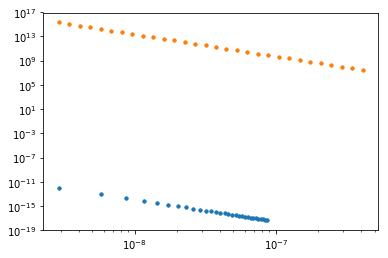

In [48]:
plt.loglog(f_red_test_psr2/u.yr.to('s'),A_red_test_psr2,'.')
plt.loglog(f_red_test_psr3,A_red_test_psr3,'.')

In [42]:
#f_GWB,Amp_GWB = MyT.createGWB(t2psr, Amp=1.3e-15, gam=13./3., seed=seed_gwb_1)

In [43]:
#plt.loglog(f_GWB,Amp_GWB,'.')

for ii,p in enumerate(t2psr):

    ## make ideal
    LT.make_ideal(p)

    ## add efacs
    LT.add_efac(p, efac = noise_dict[p.name]['efacs'][:,1], 
                flagid = 'f', flags = noise_dict[p.name]['efacs'][:,0], 
                seed = seed_efac + ii)

    ## add equads
    LT.add_equad(p, equad = noise_dict[p.name]['equads'][:,1], 
                 flagid = 'f', flags = noise_dict[p.name]['equads'][:,0], 
                 seed = seed_equad + ii)

    ## add jitter
    try: #Only NANOGrav Pulsars have ECORR
        LT.add_jitter(p, ecorr = noise_dict[p.name]['ecorrs'][:,1], 
                      flagid='f', flags = noise_dict[p.name]['ecorrs'][:,0], 
                      coarsegrain = 1.0/86400.0, seed=seed_jitter + ii)
    except KeyError:
        pass

    ## add red noise
    LT.add_rednoise(p, noise_dict[p.name]['RN_Amp'], noise_dict[p.name]['RN_gamma'], 
                    components = 30, seed = seed_red + ii)
    
    print(ii, p.name)

#Create GWB
#Takes a list of libstempo pulsar objects as input.
LT.createGWB(t2psr, Amp=1.3e-15, gam=13./3., seed=seed_gwb_1)
LT.createGWB(t2psr, Amp=1.0e-15, gam=7./3., seed=seed_gwb_2)

#Load into enterprise
psrs = []
for p in t2psr:
    psrs.append(Pulsar(p))

#Save sim pulsars to a pickle file
with open(psr_pickle_file,'wb') as psrfile:
    pickle.dump(psrs,psrfile)
    psrfile.close()